In [1]:
import os
import numpy as np
import pandas as pd
import xgboost
import xgboost as xgb
import optuna
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error 
import json


import joblib

logical_cores = os.cpu_count()
print(f"Number of logical CPU cores: {logical_cores}")

num_workers = max(1, logical_cores // 2)
print(f"Number of workers set to: {num_workers}")

def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        return False

gpu_available = is_gpu_available()
print(f"GPU available: {gpu_available}")

print(xgboost.build_info())

Number of logical CPU cores: 16
Number of workers set to: 8
GPU available: True
{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [12, 4], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [2, 3, 2], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'C:\\Users\\ng_mi\\Anaconda\\envs\\pytorch-gpu\\Lib\\site-packages\\xgboost\\lib\\xgboost.dll'}


In [2]:
os.makedirs('../feature-importances/xbclassifier', exist_ok=True)
os.makedirs('../feature-importances/xbregressor', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbregressor', exist_ok=True)


path = '../data/train'

ticker_list = []

if os.path.exists(path):
    ticker_list = [os.path.splitext(f)[0] for f in os.listdir(path) if f.endswith('.csv')]


In [3]:
def load_or_create_ticker_df(csv_file_path):
    """
    Load the existing ticker DataFrame from a CSV file if it exists,
    otherwise create a new DataFrame with predefined column types.
    Ensure the DataFrame has the specified columns, add any missing columns,
    and rearrange the columns in alphabetical order, excluding 'Ticker_Symbol'.

    Args:
    csv_file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loaded or newly created DataFrame.
    """
    # Define the column types
    column_types = {
        "Ticker_Symbol": str,
        "Best_Cov1D_Classification_Accuracy": float,
        "Best_Cov1D_Classification_Path": str,
        "Best_Cov1D_Regression_RMSE": float,
        "Best_Cov1D_Regression_Path": str,
        "Best_LSTM_Classification_Accuracy": float,
        "Best_LSTM_Classification_Path": str,
        "Best_LSTM_Regression_RMSE": float,
        "Best_LSTM_Regression_Path": str,
        "Best_Transformer_Classification_Accuracy": float,
        "Best_Transformer_Classification_Path": str,
        "Best_Transformer_Regression_RMSE": float,
        "Best_Transformer_Regression_Path": str,
        "Best_XGBClassifier_Classification_Accuracy": float,
        "Best_XGBClassifier_Classification_Path": str,
        "Best_XGBRegressor_Regression_RMSE": float,
        "Best_XGBRegressor_Regression_Path": str
    }


    if os.path.isfile(csv_file_path):
        # Load the existing file into a DataFrame
        ticker_df = pd.read_csv(csv_file_path)
        
        # Ensure all specified columns are present
        for column, dtype in column_types.items():
            if column not in ticker_df.columns:
                ticker_df[column] = pd.Series(dtype=dtype)
        
        # Reorder columns alphabetically, excluding 'Ticker_Symbol'
        columns = ["Ticker_Symbol"] + sorted([col for col in ticker_df.columns if col != "Ticker_Symbol"])
        ticker_df = ticker_df[columns]
    else:
        # Create a new DataFrame with the specified column types
        ticker_df = pd.DataFrame(columns=column_types.keys()).astype(column_types)
    
    return ticker_df

In [4]:
def delete_hyperparameter_search_model(ticker_symbol, model_type):
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    xbclassifier_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    xbregressor_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    xbclassifier_params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    xbregressor_params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'

    if model_type == "xbclassifier":
        if os.path.isfile(xbclassifier_model_path):
            os.remove(xbclassifier_model_path)
            print(f"Deleted {xbclassifier_model_path}")
        if os.path.isfile(xbclassifier_params_path):
            os.remove(xbclassifier_params_path)
            print(f"Deleted {xbclassifier_params_path}")
    
    if model_type == "xbregressor":
        if os.path.isfile(xbregressor_model_path):
            os.remove(xbregressor_model_path)
            print(f"Deleted {xbregressor_model_path}")
        if os.path.isfile(xbregressor_params_path):
            os.remove(xbregressor_params_path)
            print(f"Deleted {xbregressor_params_path}")

    if os.path.isfile(csv_path):
        ticker_df = pd.read_csv(csv_path)
        if ticker_symbol in ticker_df['Ticker_Symbol'].values:
            if model_type == "xbclassifier":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [pd.NA, pd.NA]
            if model_type == "xbregressor":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [pd.NA, pd.NA]
            ticker_df.to_csv(csv_path, index=False)
            print(f"Deleted {ticker_symbol} from {csv_path}")
        else:
            print(f"{ticker_symbol} not found in {csv_path}")
    else:
        print(f"{csv_path} does not exist")


In [5]:
def training_preprocess_data(df):
    if df.isna().sum().sum() > 0 or df.isin([float('inf'), float('-inf')]).sum().sum() > 0:
        df = df.replace([float('inf'), float('-inf')], float('nan')).dropna()

    for idx, col in enumerate(df.columns):
        print(f"{idx}: {col}")

    df = df.dropna()

    columns_to_drop = [
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date'
    ]
    X = df.drop(columns=columns_to_drop)

    # Define the list of specific columns to keep
    columns_to_keep = [
        'RSI', 'EMA', 'ADX', 'PATTERN_SUM'
    ]
    
    # Select only the specified columns
    #X = df[columns_to_keep]
    
    y_classifier = (np.sign(df['DAILY_MIDPRICE_CHANGE']) >= 0).astype(int)
    y_regressor = df['DAILY_MIDPRICE_CHANGE']

    return X, y_classifier, y_regressor

In [6]:
def xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")
    
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'use_label_encoder': False,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        # Assuming X and y are your features and labels respectively
        X_train = X[::2]  # Odd-numbered rows (0-based index)
        X_valid = X[1::2]  # Even-numbered rows (0-based index)
        y_train = y[::2]  # Corresponding labels for odd-numbered rows
        y_valid = y[1::2]  # Corresponding labels for even-numbered rows
        model = XGBClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, preds)
        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBClassifier_Classification_Accuracy'].values[0]
        if pd.isnull(current_score) or study.best_value > current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")
            
             # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model accuracy: {current_score} is better for {ticker_symbol} than accuracy: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [study.best_value], 'Best_XGBClassifier_Classification_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"Parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")

    if hyperparameter_search:
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)

    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    # Assuming X and y are your features and labels respectively
    X_train = X[::2]  # Odd-numbered rows (0-based index)
    X_valid = X[1::2]  # Even-numbered rows (0-based index)
    y_train = y[::2]  # Corresponding labels for odd-numbered rows
    y_valid = y[1::2]  # Corresponding labels for even-numbered rows

    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBClassifier(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    print(f"Validation accuracy for {ticker_symbol}: {accuracy:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [accuracy, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [accuracy], 'Best_XGBClassifier_Classification_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with accuracy: {accuracy:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)
  
    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [7]:
def xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")
        
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        # Assuming X and y are your features and labels respectively
        X_train = X[::2]  # Odd-numbered rows (0-based index)
        X_valid = X[1::2]  # Even-numbered rows (0-based index)
        y_train = y[::2]  # Corresponding labels for odd-numbered rows
        y_valid = y[1::2]  # Corresponding labels for even-numbered rows
        model = XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        rmse = root_mean_squared_error (y_valid, preds)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_params.update(study.best_trial.params)

    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBRegressor_Regression_RMSE'].values[0]
        if pd.isnull(current_score) or study.best_value < current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")

            # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model MSE: {current_score} is better for {ticker_symbol} than MSE: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [study.best_value], 'Best_XGBRegressor_Regression_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")

    if hyperparameter_search:
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        
    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    # Assuming X and y are your features and labels respectively
    X_train = X[::2]  # Odd-numbered rows (0-based index)
    X_valid = X[1::2]  # Even-numbered rows (0-based index)
    y_train = y[::2]  # Corresponding labels for odd-numbered rows
    y_valid = y[1::2]  # Corresponding labels for even-numbered rows

    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBRegressor(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    rmse = root_mean_squared_error (y_valid, preds)
    
    print(f"Validation RSME for {ticker_symbol}: {rmse:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [rmse, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [rmse], 'Best_XGBRegressor_Regression_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with RSME: {rmse:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)

    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [8]:
for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/train/{ticker_symbol}.csv")
    X, y_classifier, y_regressor = training_preprocess_data(dataframe)
    xbclassifier_resume_training(X, y_classifier, gpu_available, ticker_symbol, True, True)
    xbregressor_resume_training(X, y_regressor, gpu_available, ticker_symbol, True, True)


[I 2024-09-11 09:35:19,818] A new study created in memory with name: no-name-1b40ed43-25b9-484a-b897-f73d4d917f70


Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:35:20,200] Trial 0 finished with value: 0.75 and parameters: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.2540202423934589, 'subsample': 0.7432231407406145, 'colsample_bytree': 0.7433130011213702, 'gamma': 4.982269169718289, 'lambda': 0.0002442267906472985, 'alpha': 0.45322564119110176}. Best is trial 0 with value: 0.75.
[I 2024-09-11 09:35:20,437] Trial 1 finished with value: 0.75 and parameters: {'n_estimators': 815, 'max_depth': 4, 'learning_rate': 0.06937110520322773, 'subsample': 0.8036569953647799, 'colsample_bytree': 0.567926405404037, 'gamma': 1.3625375051870514, 'lambda': 0.00010697716002169769, 'alpha': 1.391964817661722e-05}. Best is trial 0 with value: 0.75.
[I 2024-09-11 09:35:20,692] Trial 2 finished with value: 0.7443181818181818 and parameters: {'n_estimators': 240, 'max_depth': 10, 'learning_rate': 0.06360667544986211, 'subsample': 0.9030163922365106, 'colsample_bytree': 0.7296951753537129, 'gamma': 3.088721842230417, 'lambda': 5.509321596

Model for CL=F saved with accuracy: 0.8238636363636364
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-11 09:35:55,614] A new study created in memory with name: no-name-9d584788-68bc-4fe9-8c4f-d6c5b4fcdd5b


Validation accuracy for CL=F: 0.8239
Model for CL=F saved with accuracy: 0.8239
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:35:56,274] Trial 0 finished with value: 1.1197664385907178 and parameters: {'n_estimators': 111, 'max_depth': 10, 'learning_rate': 0.012785576800246461, 'subsample': 0.5692305121450506, 'colsample_bytree': 0.7558188128213628, 'gamma': 3.247375229998668, 'lambda': 0.00020921532142647269, 'alpha': 0.0012156282127855668}. Best is trial 0 with value: 1.1197664385907178.
[I 2024-09-11 09:35:56,486] Trial 1 finished with value: 1.1199376780007866 and parameters: {'n_estimators': 611, 'max_depth': 8, 'learning_rate': 0.13234110811968944, 'subsample': 0.5608939852979283, 'colsample_bytree': 0.8440519647182974, 'gamma': 2.9539133195751033, 'lambda': 0.021763216868950858, 'alpha': 0.01325396790106778}. Best is trial 0 with value: 1.1197664385907178.
[I 2024-09-11 09:35:56,715] Trial 2 finished with value: 1.1259297753511588 and parameters: {'n_estimators': 327, 'max_depth': 7, 'learning_rate': 0.1902586340679445, 'subsample': 0.6303562768673253, 'colsample_bytree': 0.81850550359

Best model for CL=F saved with RMSE: 1.0232288643176373
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-11 09:36:30,675] A new study created in memory with name: no-name-a743c9e0-3f21-4799-8464-ab6fe7401d8e


Validation RSME for CL=F: 1.0232
Model for CL=F saved with RSME: 1.0232
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:36:30,964] Trial 0 finished with value: 0.6704545454545454 and parameters: {'n_estimators': 554, 'max_depth': 4, 'learning_rate': 0.22847565011971147, 'subsample': 0.7914360833010023, 'colsample_bytree': 0.9275433460119019, 'gamma': 3.817952292289815, 'lambda': 2.026147290850024e-07, 'alpha': 0.07338076593734436}. Best is trial 0 with value: 0.6704545454545454.
[I 2024-09-11 09:36:31,360] Trial 1 finished with value: 0.6818181818181818 and parameters: {'n_estimators': 422, 'max_depth': 10, 'learning_rate': 0.14742386248753978, 'subsample': 0.6998666161124644, 'colsample_bytree': 0.9905772785935163, 'gamma': 2.680822633922065, 'lambda': 0.0001292611519326385, 'alpha': 5.807803829272352e-07}. Best is trial 1 with value: 0.6818181818181818.
[I 2024-09-11 09:36:31,613] Trial 2 finished with value: 0.6761363636363636 and parameters: {'n_estimators': 572, 'max_depth': 6, 'learning_rate': 0.16632868418808408, 'subsample': 0.8434073946208016, 'colsample_bytree': 0.778697726666

Model for NVDA saved with accuracy: 0.7102272727272727
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-11 09:37:00,967] A new study created in memory with name: no-name-48f50fd6-10d6-47ec-b543-916d01870200
[I 2024-09-11 09:37:01,141] Trial 0 finished with value: 1.1902849592056859 and parameters: {'n_estimators': 827, 'max_depth': 3, 'learning_rate': 0.2291352435775951, 'subsample': 0.6447321535019788, 'colsample_bytree': 0.7158006237522619, 'gamma': 3.7061395864621858, 'lambda': 8.063934443138742e-07, 'alpha': 0.010014642389379717}. Best is trial 0 with value: 1.1902849592056859.


Validation accuracy for NVDA: 0.7102
Model for NVDA saved with accuracy: 0.7102
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:37:01,506] Trial 1 finished with value: 1.204142157500791 and parameters: {'n_estimators': 849, 'max_depth': 10, 'learning_rate': 0.1661061966676063, 'subsample': 0.8285225345015961, 'colsample_bytree': 0.8928322497922708, 'gamma': 2.446188723219314, 'lambda': 0.1131700124406764, 'alpha': 9.474631395494271e-08}. Best is trial 0 with value: 1.1902849592056859.
[I 2024-09-11 09:37:01,917] Trial 2 finished with value: 1.1384884225003296 and parameters: {'n_estimators': 583, 'max_depth': 3, 'learning_rate': 0.021498328984490226, 'subsample': 0.5846435870379559, 'colsample_bytree': 0.9201133565677033, 'gamma': 4.379419055879884, 'lambda': 0.03873743094253166, 'alpha': 1.2769892301231411e-06}. Best is trial 2 with value: 1.1384884225003296.
[I 2024-09-11 09:37:02,242] Trial 3 finished with value: 1.1612092657075506 and parameters: {'n_estimators': 220, 'max_depth': 6, 'learning_rate': 0.03333265929876899, 'subsample': 0.8638437428167307, 'colsample_bytree': 0.781590390748768

Best model for NVDA saved with RMSE: 1.0922072203793876
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-11 09:37:30,698] A new study created in memory with name: no-name-77f422e5-878a-41b2-bf1b-72d494b820d5


Validation RSME for NVDA: 1.0922
Model for NVDA saved with RSME: 1.0922
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:37:30,879] Trial 0 finished with value: 0.572972972972973 and parameters: {'n_estimators': 385, 'max_depth': 10, 'learning_rate': 0.2921389765657356, 'subsample': 0.6338871120544052, 'colsample_bytree': 0.9211234493376692, 'gamma': 3.7979578750855696, 'lambda': 0.011181848692047346, 'alpha': 1.9280453239965243e-06}. Best is trial 0 with value: 0.572972972972973.
[I 2024-09-11 09:37:31,238] Trial 1 finished with value: 0.5621621621621622 and parameters: {'n_estimators': 624, 'max_depth': 6, 'learning_rate': 0.016699081177748078, 'subsample': 0.9361095549657842, 'colsample_bytree': 0.8592773618767015, 'gamma': 3.080676994943517, 'lambda': 0.0033800013752214616, 'alpha': 3.367343077595317e-07}. Best is trial 0 with value: 0.572972972972973.
[I 2024-09-11 09:37:31,442] Trial 2 finished with value: 0.5027027027027027 and parameters: {'n_estimators': 198, 'max_depth': 7, 'learning_rate': 0.10164686047410022, 'subsample': 0.6216528359766066, 'colsample_bytree': 0.540294988621

Model for SGDUSD=X saved with accuracy: 0.6108108108108108
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-11 09:37:59,791] A new study created in memory with name: no-name-441fff95-2ce0-4f7d-a059-a98377724b40


Validation accuracy for SGDUSD=X: 0.6108
Model for SGDUSD=X saved with accuracy: 0.6108
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:38:00,069] Trial 0 finished with value: 0.001724455826461645 and parameters: {'n_estimators': 683, 'max_depth': 4, 'learning_rate': 0.12015565456791368, 'subsample': 0.5466581824577519, 'colsample_bytree': 0.5323425759215555, 'gamma': 4.043903353938726, 'lambda': 4.654485342124469e-08, 'alpha': 2.857215172433916e-06}. Best is trial 0 with value: 0.001724455826461645.
[I 2024-09-11 09:38:00,264] Trial 1 finished with value: 0.0017263953616293267 and parameters: {'n_estimators': 877, 'max_depth': 5, 'learning_rate': 0.21926368130073862, 'subsample': 0.6884876783996771, 'colsample_bytree': 0.5791727731826618, 'gamma': 3.9317725725433212, 'lambda': 8.24375648432876e-06, 'alpha': 0.30603469293289787}. Best is trial 0 with value: 0.001724455826461645.
[I 2024-09-11 09:38:00,509] Trial 2 finished with value: 0.0017250156561381493 and parameters: {'n_estimators': 589, 'max_depth': 10, 'learning_rate': 0.08285192616645883, 'subsample': 0.5894463221853528, 'colsample_bytree': 0.

Best model for SGDUSD=X saved with RMSE: 0.0017239487876665664
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.
Validation RSME for SGDUSD=X: 0.0017


[I 2024-09-11 09:38:24,101] A new study created in memory with name: no-name-212151bb-fa55-409d-8063-9e5a7fc72863


Model for SGDUSD=X saved with RSME: 0.0017
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:38:24,336] Trial 0 finished with value: 0.5783783783783784 and parameters: {'n_estimators': 421, 'max_depth': 6, 'learning_rate': 0.24928701917981622, 'subsample': 0.6388981087031802, 'colsample_bytree': 0.7532973086327325, 'gamma': 4.834183033271118, 'lambda': 2.097257941893186e-08, 'alpha': 0.9889926832169794}. Best is trial 0 with value: 0.5783783783783784.
[I 2024-09-11 09:38:24,552] Trial 1 finished with value: 0.4972972972972973 and parameters: {'n_estimators': 913, 'max_depth': 8, 'learning_rate': 0.22507620445950832, 'subsample': 0.967521075872015, 'colsample_bytree': 0.5204265377496452, 'gamma': 3.3920555670368744, 'lambda': 1.6577597436519338e-05, 'alpha': 0.012946412682201727}. Best is trial 0 with value: 0.5783783783783784.
[I 2024-09-11 09:38:24,856] Trial 2 finished with value: 0.5783783783783784 and parameters: {'n_estimators': 595, 'max_depth': 10, 'learning_rate': 0.21655182899864325, 'subsample': 0.9333996041130346, 'colsample_bytree': 0.8516662374313

Model for USDSGD=X saved with accuracy: 0.6054054054054054
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.
Validation accuracy for USDSGD=X: 0.6054
Model for USDSGD=X saved with accuracy: 0.6054
Feature importances for USDSGD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 09:38:50,788] Trial 0 finished with value: 0.003105187549227155 and parameters: {'n_estimators': 192, 'max_depth': 8, 'learning_rate': 0.23349965367143266, 'subsample': 0.5721702651776217, 'colsample_bytree': 0.8379137966143645, 'gamma': 0.12575262083482086, 'lambda': 0.08310991704507088, 'alpha': 0.36878314305600846}. Best is trial 0 with value: 0.003105187549227155.
[I 2024-09-11 09:38:50,963] Trial 1 finished with value: 0.003104195952020995 and parameters: {'n_estimators': 265, 'max_depth': 10, 'learning_rate': 0.039268480716485483, 'subsample': 0.8844775688121795, 'colsample_bytree': 0.8729804715871883, 'gamma': 2.555216856276752, 'lambda': 0.236985539162381, 'alpha': 6.627652103834535e-05}. Best is trial 1 with value: 0.003104195952020995.
[I 2024-09-11 09:38:51,137] Trial 2 finished with value: 0.0031027220497942907 and parameters: {'n_estimators': 673, 'max_depth': 7, 'learning_rate': 0.17808918722135317, 'subsample': 0.8007545626497925, 'colsample_bytree': 0.9486

Best model for USDSGD=X saved with RMSE: 0.0031008282001256165
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.
Validation RSME for USDSGD=X: 0.0031
Model for USDSGD=X saved with RSME: 0.0031
Feature importances for USDSGD=X saved.


CL=F at 2024-06-12 , Actual Price: -0.3199996948242187, xbregressor_result: [-0.07451533], xbclassifier_result: [1], final: [-0.07451533]
CL=F at 2024-06-13 , Actual Price: 0.160003662109375, xbregressor_result: [-0.08594109], xbclassifier_result: [1], final: [-0.08594109]
CL=F at 2024-06-14 , Actual Price: 0.8800010681152344, xbregressor_result: [0.30998948], xbclassifier_result: [1], final: [0.30998948]
CL=F at 2024-06-17 , Actual Price: 1.399993896484375, xbregressor_result: [0.64345264], xbclassifier_result: [1], final: [0.64345264]
CL=F at 2024-06-18 , Actual Price: 1.0500030517578125, xbregressor_result: [0.30808726], xbclassifier_result: [1], final: [0.30808726]
CL=F at 2024-06-20 , Actual Price: -0.7000007629394531, xbregressor_result: [0.11761013], xbclassifier_result: [1], final: [0.11761013]
CL=F at 2024-06-21 , Actual Price: -0.0649986267089843, xbregressor_result: [-0.7241565], xbclassifier_result: -1, final: [-0.7241565]
CL=F at 2024-06-24 , Actual Price: 0.22000122070312

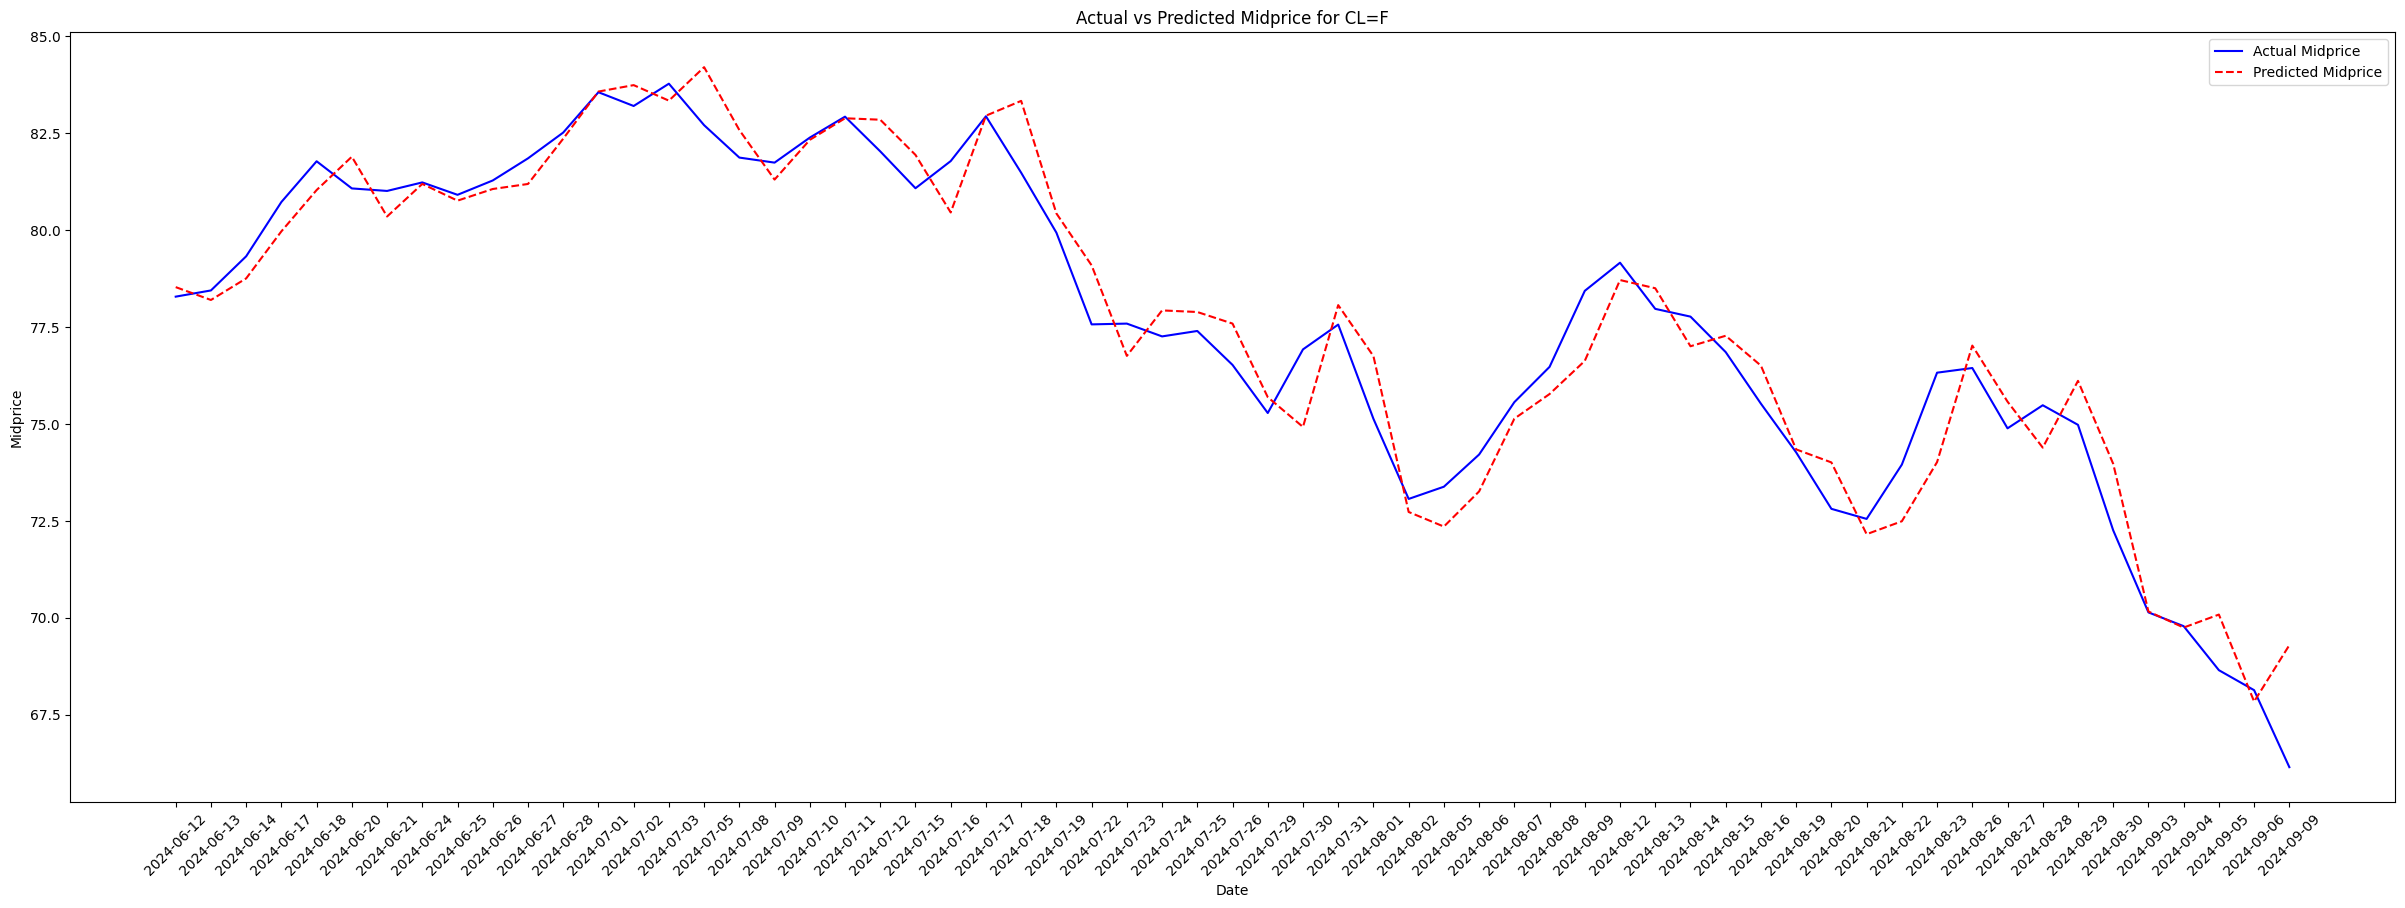

NVDA at 2024-06-12 , Actual Price: 3.7550048828125, xbregressor_result: [0.72439814], xbclassifier_result: [1], final: [0.72439814]
NVDA at 2024-06-13 , Actual Price: 2.0999984741210938, xbregressor_result: [0.9144002], xbclassifier_result: [1], final: [0.9144002]
NVDA at 2024-06-14 , Actual Price: 1.0749969482421875, xbregressor_result: [0.9144002], xbclassifier_result: [1], final: [0.9144002]
NVDA at 2024-06-17 , Actual Price: 1.8550033569335935, xbregressor_result: [0.08225045], xbclassifier_result: -1, final: [0.08225045]
NVDA at 2024-06-18 , Actual Price: 1.6299972534179688, xbregressor_result: [0.9384398], xbclassifier_result: [1], final: [0.9384398]
NVDA at 2024-06-20 , Actual Price: -7.674995422363281, xbregressor_result: [-0.06466636], xbclassifier_result: -1, final: [-0.06466636]
NVDA at 2024-06-21 , Actual Price: -6.215003967285156, xbregressor_result: [0.5822708], xbclassifier_result: [1], final: [0.5822708]
NVDA at 2024-06-24 , Actual Price: 1.6599998474121094, xbregressor

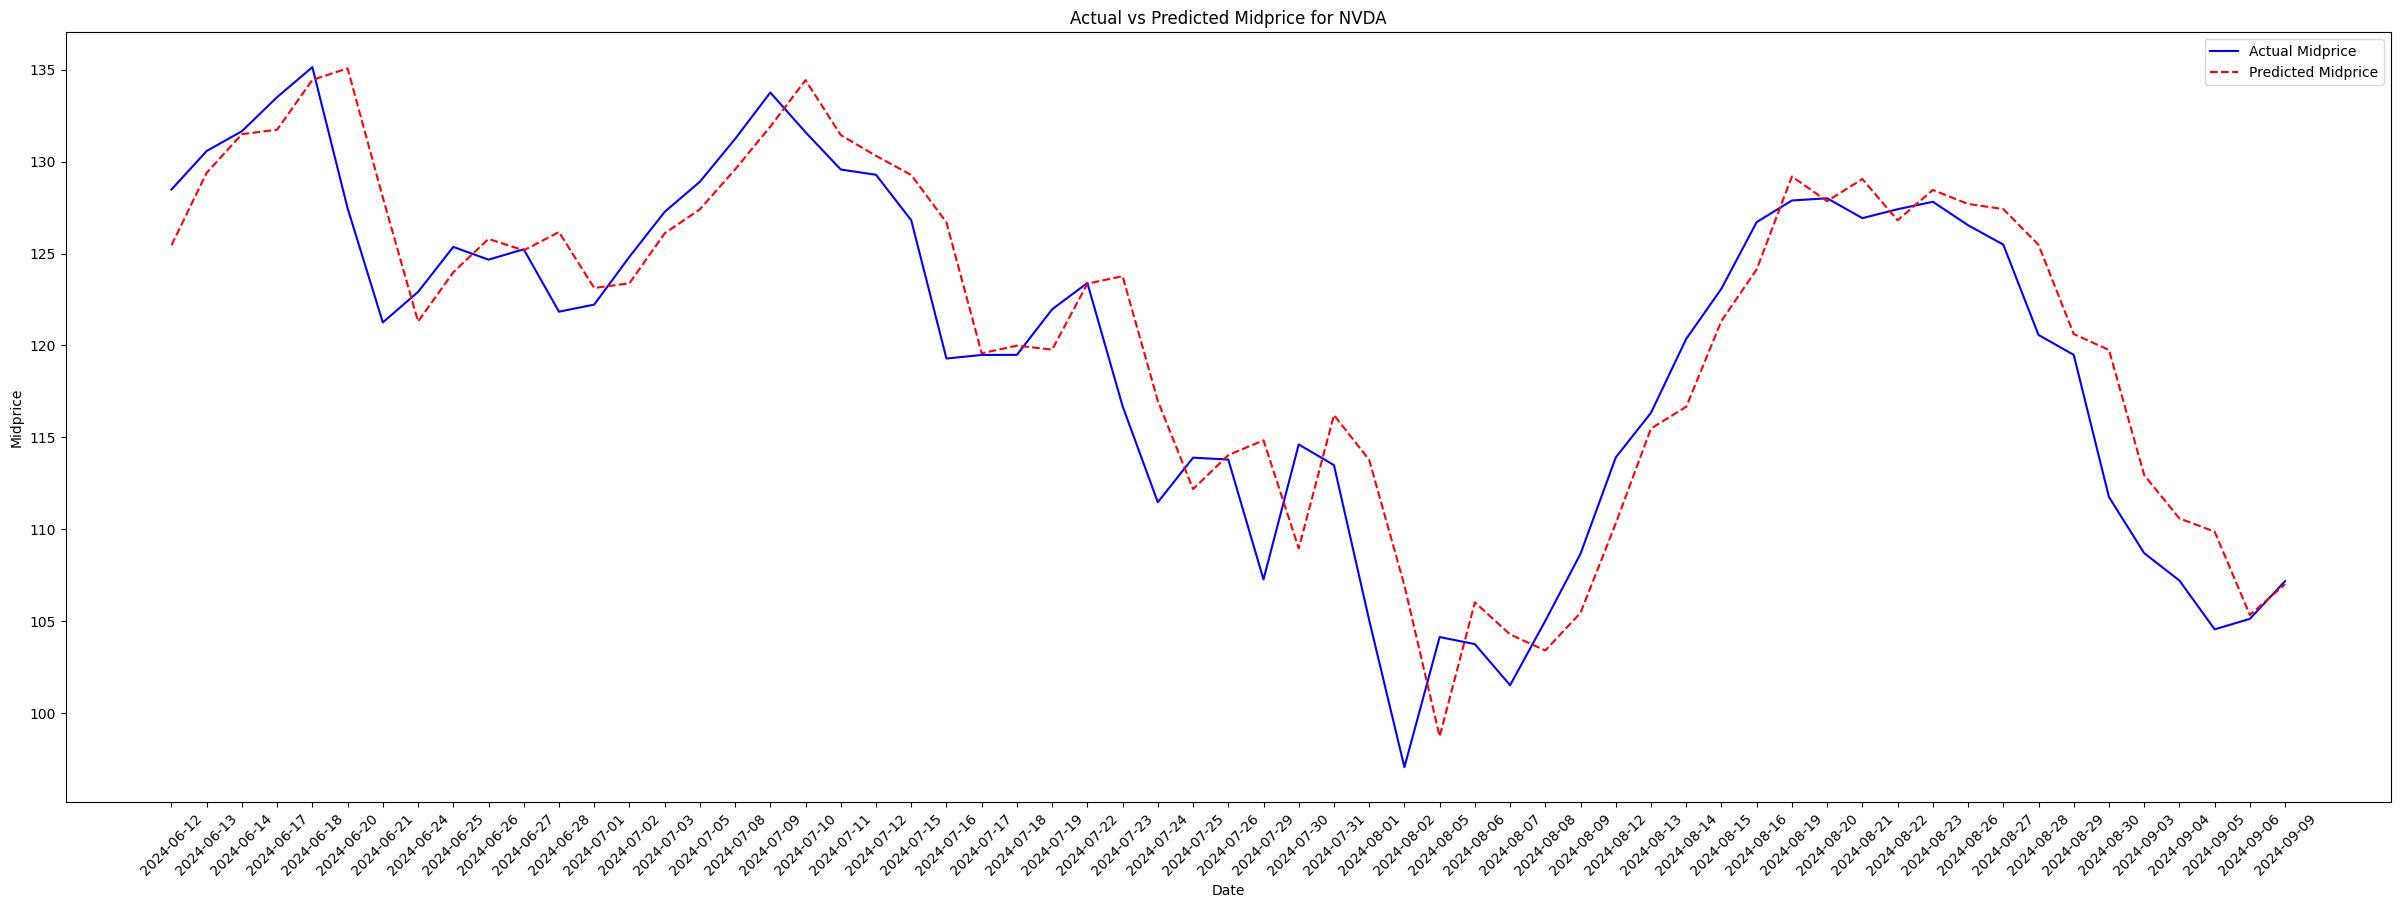

SGDUSD=X at 2024-06-13 , Actual Price: -0.0023589730262756, xbregressor_result: [1.3496792e-05], xbclassifier_result: [1], final: [1.3496792e-05]
SGDUSD=X at 2024-06-14 , Actual Price: -7.605552673339844e-05, xbregressor_result: [1.3496792e-05], xbclassifier_result: [1], final: [1.3496792e-05]
SGDUSD=X at 2024-06-17 , Actual Price: 1.7404556274414062e-05, xbregressor_result: [1.3496792e-05], xbclassifier_result: [1], final: [1.3496792e-05]
SGDUSD=X at 2024-06-18 , Actual Price: 0.001173049211502, xbregressor_result: [1.3496792e-05], xbclassifier_result: [1], final: [1.3496792e-05]
SGDUSD=X at 2024-06-19 , Actual Price: -0.0008939206600189, xbregressor_result: [1.3496792e-05], xbclassifier_result: [1], final: [1.3496792e-05]
SGDUSD=X at 2024-06-20 , Actual Price: -0.0010221302509307, xbregressor_result: [1.3496792e-05], xbclassifier_result: -1, final: [1.3496792e-05]
SGDUSD=X at 2024-06-21 , Actual Price: 0.0002277195453643, xbregressor_result: [1.3496792e-05], xbclassifier_result: [1],

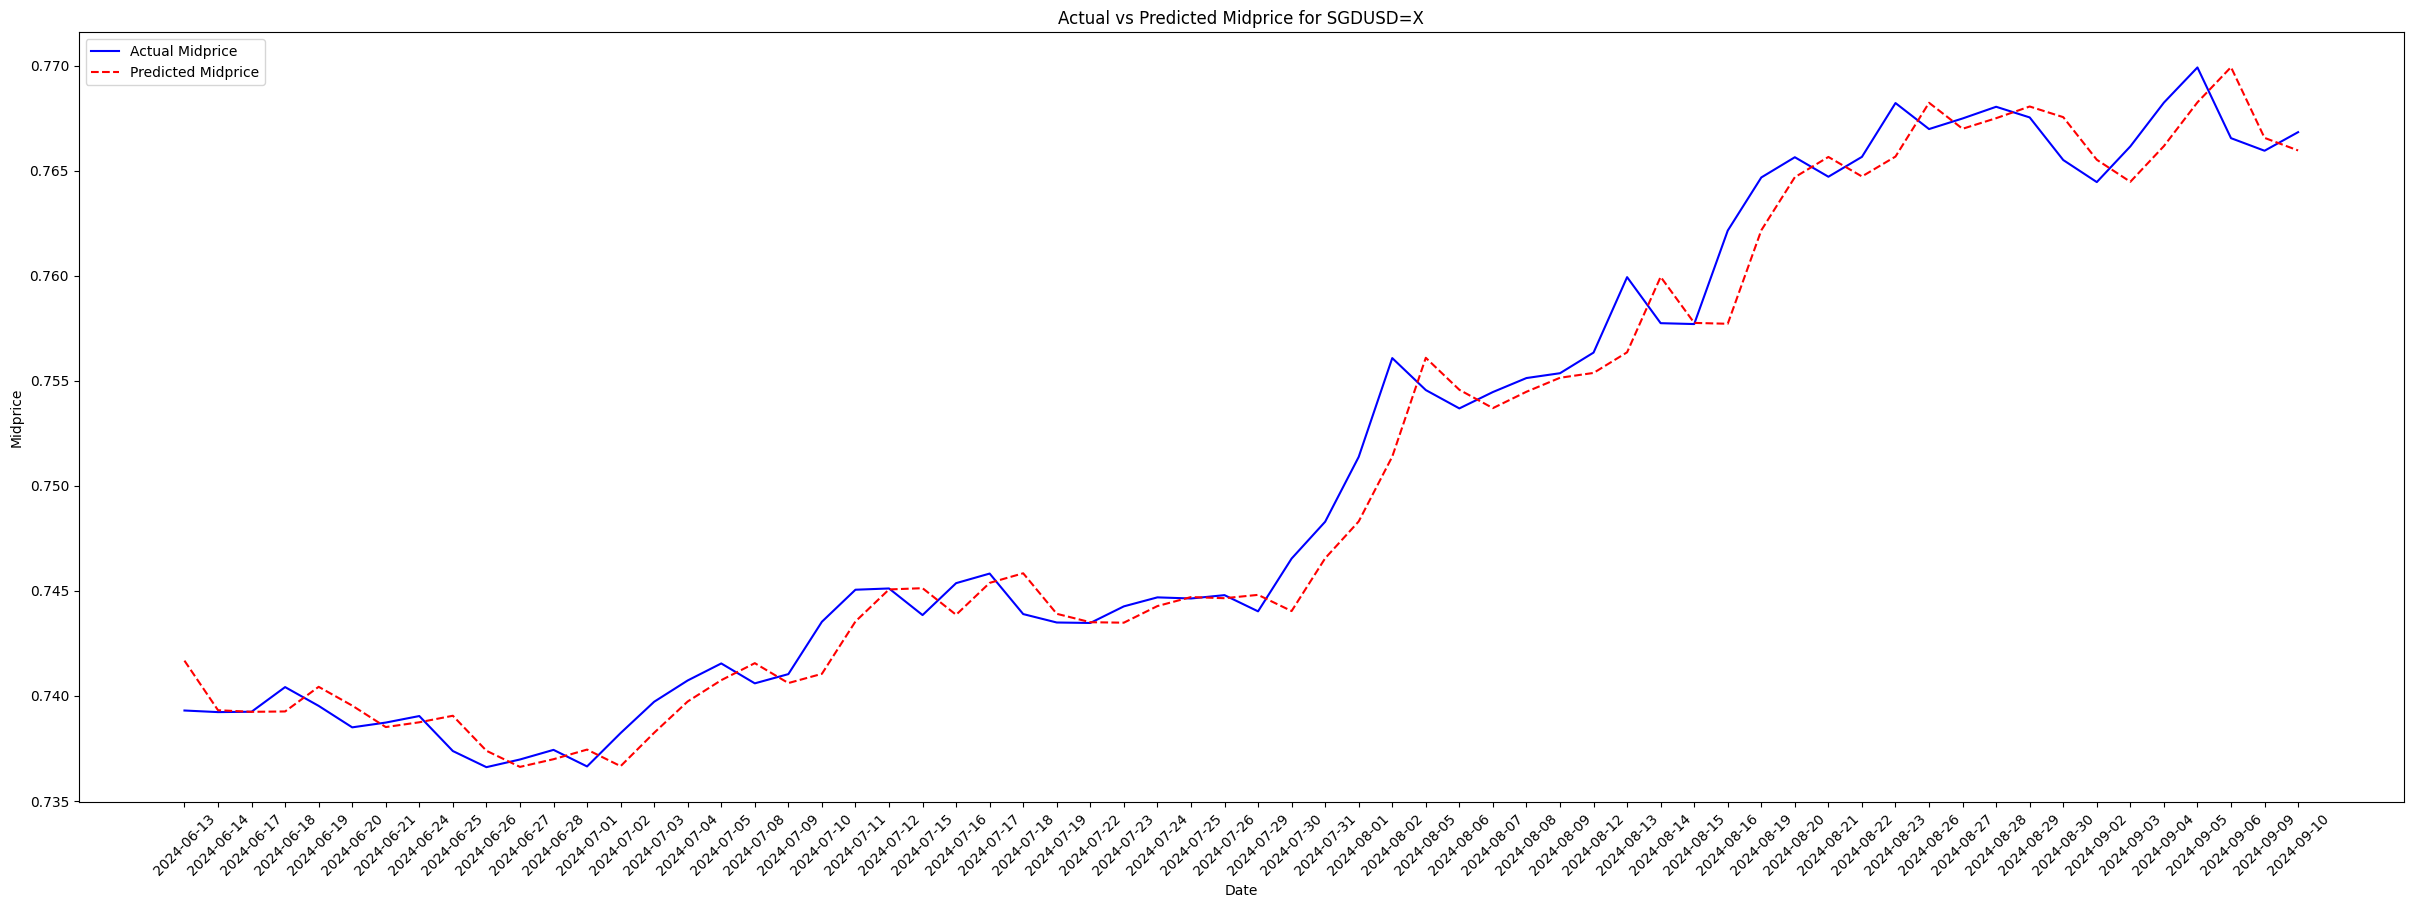

USDSGD=X at 2024-06-13 , Actual Price: 0.0043050646781921, xbregressor_result: [-2.38051e-05], xbclassifier_result: -1, final: [-2.38051e-05]
USDSGD=X at 2024-06-14 , Actual Price: 0.0001349449157714, xbregressor_result: [-2.38051e-05], xbclassifier_result: -1, final: [-2.38051e-05]
USDSGD=X at 2024-06-17 , Actual Price: -2.992153167724609e-05, xbregressor_result: [-2.38051e-05], xbclassifier_result: -1, final: [-2.38051e-05]
USDSGD=X at 2024-06-18 , Actual Price: -0.0021450519561767, xbregressor_result: [-2.38051e-05], xbclassifier_result: -1, final: [-2.38051e-05]
USDSGD=X at 2024-06-19 , Actual Price: 0.0016350150108337, xbregressor_result: [-2.38051e-05], xbclassifier_result: -1, final: [-2.38051e-05]
USDSGD=X at 2024-06-20 , Actual Price: 0.0018699765205383, xbregressor_result: [-2.38051e-05], xbclassifier_result: -1, final: [-2.38051e-05]
USDSGD=X at 2024-06-21 , Actual Price: -0.0004149675369262, xbregressor_result: [-2.38051e-05], xbclassifier_result: -1, final: [-2.38051e-05]


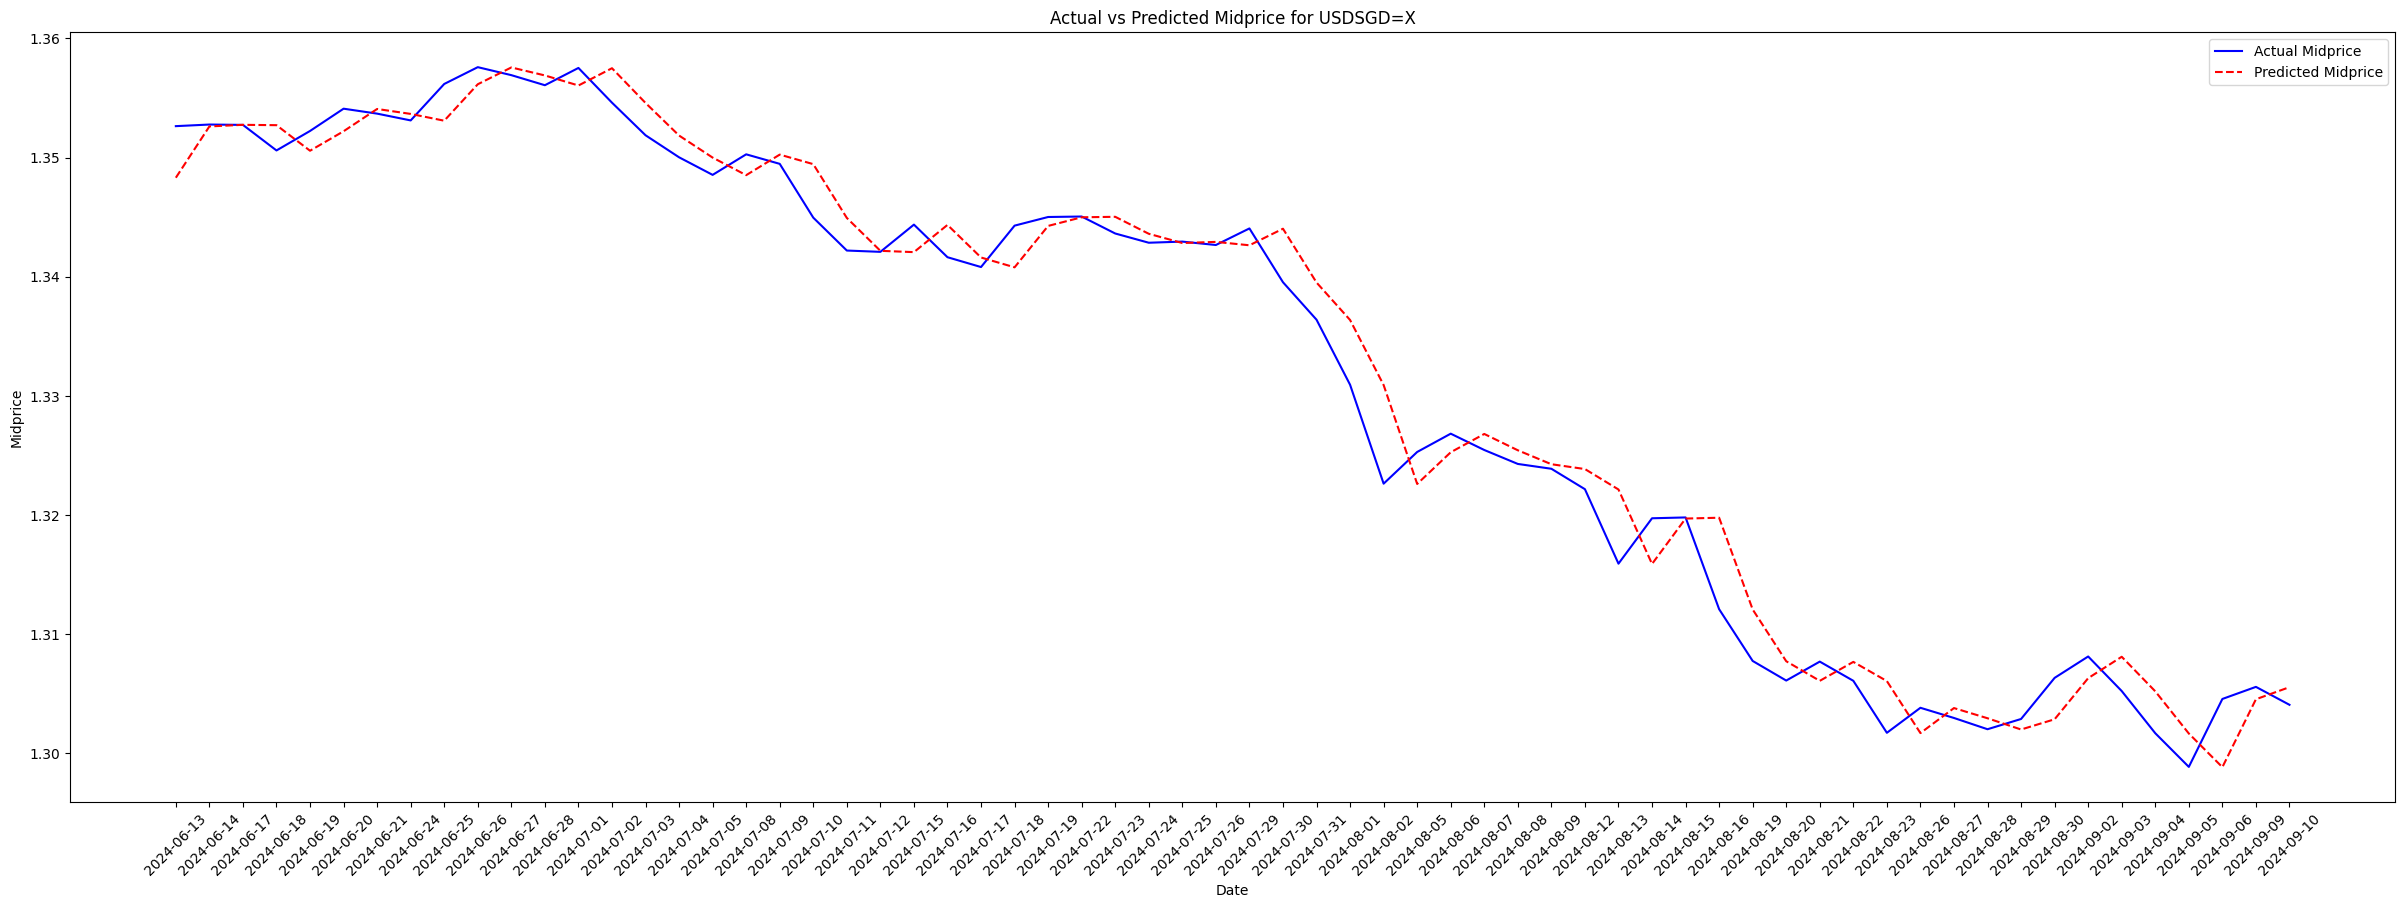

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary functions defined elsewhere:
# xbclassifier_predict, xbregressor_predict, root_mean_squared_error

for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/test/{ticker_symbol}.csv")
    X = dataframe.drop(columns=[
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date'
    ])

    sign_correct = 0
    total_predictions = 0
    actual_changes = []
    predicted_changes = []
    predicted_midprice = []

    # Loop through the dataframe starting from row 31 (index 30) to the second-to-last row
    for index, row in X.iloc[30:-1].iterrows():
        row_data = row.to_frame().T.reset_index(drop=True)  # Convert row to DataFrame and reset index
        
        xbclassifier_result = xbclassifier_predict(row_data, ticker_symbol)
        if xbclassifier_result == 0:
            xbclassifier_result = -1  # Adjust predicted_sign if it is 0
        
        xbregressor_result = xbregressor_predict(row_data, ticker_symbol)
        #predicted_value = abs(xbregressor_result) * xbclassifier_result
        predicted_value = xbregressor_result
        
        predicted_midprice.append(dataframe.iloc[index]['DAILY_MIDPRICE'] + predicted_value)

        actual_change = dataframe.iloc[index]['DAILY_MIDPRICE_CHANGE']
        actual_sign = np.sign(actual_change)
        
        # Collect actual and predicted changes for RMSE calculation
        actual_changes.append(actual_change)
        predicted_changes.append(predicted_value)

        #predicted_sign = xbclassifier_result
        predicted_sign = np.sign(xbregressor_result)
        
        # Check if the predicted sign matches the actual sign
        if predicted_sign == actual_sign:
            sign_correct += 1
        total_predictions += 1

        print(f"{ticker_symbol} at {dataframe.iloc[index]['Date']} , Actual Price: {actual_change}, xbregressor_result: {xbregressor_result}, xbclassifier_result: {xbclassifier_result}, final: {predicted_value}")

    # Calculate sign accuracy
    sign_accuracy = sign_correct / total_predictions
    print(f"{ticker_symbol} Sign Accuracy: {sign_accuracy}")

    # Calculate RMSE
    rmse = root_mean_squared_error(actual_changes, predicted_changes)
    print(f"{ticker_symbol} RMSE: {rmse}")

    # Predict the last entry
    last_row = X.iloc[-1].to_frame().T.reset_index(drop=True)
    last_xbclassifier_result = xbclassifier_predict(last_row, ticker_symbol)
    if last_xbclassifier_result == 0:
        last_xbclassifier_result = -1  # Adjust predicted_sign if it is 0
    
    last_xbregressor_result = xbregressor_predict(last_row, ticker_symbol)
    last_predicted_value = abs(last_xbregressor_result) * last_xbclassifier_result 

    print(f"{ticker_symbol} at {dataframe.iloc[-1]['Date']} , Predicted Price: {last_predicted_value}")

    # Plotting the results for each ticker
    plt.figure(figsize=(30, 10))

    # Plot actual midprice
    plt.plot(dataframe.iloc[30:-1]['Date'], dataframe.iloc[30:-1]['NEXT_DAY_MIDPRICE'], label='Actual Midprice', color='blue')

    # Plot predicted midprice
    plt.plot(dataframe.iloc[30:-1]['Date'], predicted_midprice, label='Predicted Midprice', color='red', linestyle='--')

    # Add title and labels
    plt.title(f'Actual vs Predicted Midprice for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Midprice')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

